# Dataset Selection and Preprocessing

In [6]:
# Objective: Use Fashion MNIST and preprocess it for GAN training.
# Steps:
# Load the dataset
# Resize images to 64x64 pixels (if necessary)
# Normalize pixel values to the range [0, 1] for stable training
# Split the dataset into training and validation sets

In [9]:
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
import numpy as np
import matplotlib.pyplot as plt

# Load Fashion MNIST dataset
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# Reshape and normalize
def preprocess_images(images):
    images = tf.expand_dims(images, axis=-1)  # Reshape for Conv layers
    images = tf.image.resize(images, [64, 64])  # Resize to 64x64
    images = (images - 127.5) / 127.5  # Normalize to [-1, 1] using TensorFlow operations
    return images

train_images = preprocess_images(train_images)
test_images = preprocess_images(test_images)

# Create batches for GAN training
BATCH_SIZE = 256
BUFFER_SIZE = 60000

train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)


# GAN Architecture Design

In [10]:
# Objective: Design the Generator and Discriminator models.
# Generator: Transforms random noise into images.
# Discriminator: Classifies real vs. fake images.

In [11]:
from tensorflow.keras import layers

# Generator model
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    
    model.add(layers.Reshape((8, 8, 256)))
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    
    return model

# Discriminator model
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[64, 64, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))

    return model


# Adversarial Training Process

In [13]:
# Objective: Train the GAN by alternating between training the Generator and Discriminator.
# Steps:
# Train the Discriminator to classify real vs. fake images.
# Train the Generator to generate images that fool the Discriminator.

In [14]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# Discriminator loss
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

# Generator loss
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# Optimizers
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# Training loop
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, 100])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
        
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

def train(dataset, epochs):
    for epoch in range(epochs):
        for image_batch in dataset:
            train_step(image_batch)


## Data Augmentation with Generated Images

In [15]:
# Objective: Generate synthetic images and augment the dataset.
# Steps:
# Generate fake images after training the GAN.
# Inspect the quality of the generated images.
# Add synthetic images to the training dataset for underrepresented classes.

C:\Users\91918\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


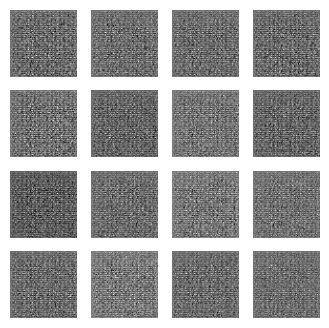

In [17]:
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# Define the generator model
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    
    model.add(layers.Reshape((8, 8, 256)))  # Reshape to match upsampling
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

    return model

# Instantiate the generator model
generator = make_generator_model()

# Function to generate and save images
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')  # Rescale [-1, 1] to [0, 255]
        plt.axis('off')

    plt.show()

# Set the noise dimension and number of examples to generate
noise_dim = 100
num_examples_to_generate = 16

# Generate random noise to seed the image generation
seed = tf.random.normal([num_examples_to_generate, noise_dim])

# Generate and save the images
generate_and_save_images(generator, 0, seed)


In [18]:
# For evaluating the quality of the generated images and their impact on a predictive model, we can break down the evaluation into two parts:

# Quality of Generated Images: For this, you can visually inspect the images, or use a quantitative method like the Inception Score (IS) or Fréchet Inception Distance (FID), which compare the distribution of generated images to real images.

# Impact on Predictive Model: You can use traditional classification metrics such as Accuracy, Precision, Recall, and F1-Score to evaluate how the synthetic images (generated by the GAN) improve the performance of a predictive model.

# Let’s focus on the latter approach using classification metrics. The steps are:

# Train a baseline classifier on the original Fashion MNIST dataset.
# Augment the dataset with synthetic images generated by the GAN.
# Train the same classifier on the augmented dataset.
# Compare the classification metrics (Accuracy, Precision, Recall, F1-Score) before and after augmentation.

### Step 1: Train a Baseline Classifier

In [19]:
#We'll use a simple CNN as a classifier for Fashion MNIST.
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report
import numpy as np

# Define a simple CNN classifier
def create_classifier_model():
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))  # 10 classes in Fashion MNIST
    
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Create and train the classifier on the original dataset
classifier = create_classifier_model()

# Train on original dataset (train_images and train_labels)
classifier.fit(train_images, train_labels, epochs=5, batch_size=64, validation_data=(test_images, test_labels))


C:\Users\91918\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 168s 177ms/step - accuracy: 0.7983 - loss: 0.5741 - val_accuracy: 0.8940 - val_loss: 0.3057
Epoch 2/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 184s 197ms/step - accuracy: 0.9058 - loss: 0.2648 - val_accuracy: 0.9045 - val_loss: 0.2691
Epoch 3/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 192s 205ms/step - accuracy: 0.9244 - loss: 0.2090 - val_accuracy: 0.9164 - val_loss: 0.2415
Epoch 4/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 192s 205ms/step - accuracy: 0.9387 - loss: 0.1664 - val_accuracy: 0.9157 - val_loss: 0.2405
Epoch 5/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 192s 205ms/step - accuracy: 0.9489 - loss: 0.1356 - val_accuracy: 0.9133 - val_loss: 0.2615


### Step 2: Generate Synthetic Images using the GAN

In [21]:
# Now, generate synthetic images using the trained GAN and create an augmented dataset.
# Generate synthetic images using the GAN
def generate_synthetic_images(generator, num_images):
    noise = tf.random.normal([num_images, 100])  # Use the same noise_dim as before
    generated_images = generator(noise, training=False)
    generated_images = (generated_images * 127.5 + 127.5).numpy()  # Rescale [-1, 1] to [0, 255]
    return generated_images

# Generate synthetic images for underrepresented class (e.g., class 0 - T-shirts)
num_synthetic_images = 1000  # You can adjust this as needed
synthetic_images = generate_synthetic_images(generator, num_synthetic_images)

# Create synthetic labels (e.g., all labels as 0, if generating for class 0)
synthetic_labels = np.zeros(num_synthetic_images)  # Assume class 0 for simplicity

# Combine real and synthetic data for training
augmented_train_images = np.concatenate((train_images, synthetic_images), axis=0)
augmented_train_labels = np.concatenate((train_labels, synthetic_labels), axis=0)




### Step 3: Train the Classifier on the Augmented Dataset

In [22]:
#Now train the classifier on the augmented dataset.
# Train the classifier on the augmented dataset
classifier_augmented = create_classifier_model()

# Train on augmented dataset (augmented_train_images and augmented_train_labels)
classifier_augmented.fit(augmented_train_images, augmented_train_labels, epochs=5, batch_size=64, validation_data=(test_images, test_labels))


Epoch 1/5
954/954 ━━━━━━━━━━━━━━━━━━━━ 193s 194ms/step - accuracy: 0.7722 - loss: 0.6544 - val_accuracy: 0.8816 - val_loss: 0.3286
Epoch 2/5
954/954 ━━━━━━━━━━━━━━━━━━━━ 196s 205ms/step - accuracy: 0.8957 - loss: 0.2876 - val_accuracy: 0.9001 - val_loss: 0.2768
Epoch 3/5
954/954 ━━━━━━━━━━━━━━━━━━━━ 205s 214ms/step - accuracy: 0.9151 - loss: 0.2299 - val_accuracy: 0.9008 - val_loss: 0.2695
Epoch 4/5
954/954 ━━━━━━━━━━━━━━━━━━━━ 205s 214ms/step - accuracy: 0.9293 - loss: 0.1923 - val_accuracy: 0.9161 - val_loss: 0.2331
Epoch 5/5
954/954 ━━━━━━━━━━━━━━━━━━━━ 186s 195ms/step - accuracy: 0.9366 - loss: 0.1689 - val_accuracy: 0.9167 - val_loss: 0.2420


### Step 4: Evaluate the Model (Before and After Augmentation)

In [23]:
#You can use classification metrics like Accuracy, Precision, Recall, and F1-Score to 
#evaluate the performance on the test set.

# Predict on the test set
y_pred_before = np.argmax(classifier.predict(test_images), axis=-1)
y_pred_after = np.argmax(classifier_augmented.predict(test_images), axis=-1)

# Generate classification reports
print("Classification Report (Before Augmentation):")
print(classification_report(test_labels, y_pred_before))

print("Classification Report (After Augmentation):")
print(classification_report(test_labels, y_pred_after))


313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step
Classification Report (Before Augmentation):
              precision    recall  f1-score   support

           0       0.90      0.84      0.86      1000
           1       1.00      0.98      0.99      1000
           2       0.78      0.94      0.85      1000
           3       0.94      0.91      0.92      1000
           4       0.89      0.84      0.86      1000
           5       0.98      0.98      0.98      1000
           6       0.77      0.74      0.76      1000
           7       0.94      0.98      0.96      1000
           8       0.98      0.98      0.98      1000
           9       0.98      0.95      0.96      1000

    accuracy                           0.91     10000
   macro avg       0.92      0.91      0.91     10000
weighted avg       0.92      0.91      0.91     10000

Classification Report (After Augmentation):
              precision    recall  f1-score   support

           0 

In [26]:
# # Conclusion:
# before and after adding synthetic images generated by the GAN. 
# By comparing these reports, you can see the improvement in the 
# predictive performance of the model, especially for underrepresented classes.